## Simple tests for grabbing frames

OpenCV has a nice wrapper around webcams. Let's test it there to get the simplest code that we would need in our library.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# define plots to be inserted interactively
import matplotlib.pyplot as plt
%matplotlib inline
import time
import cv2
cv2.__version__

'3.0.0'

In [3]:
class Source:
    def __init__(self, w=640, h=480):
        self.h, self.w = h, w
        import cv2
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.w)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.h)
      
    def grab(self):
        # grab a frame
        returned, cam_data = self.cap.read()
        data = cam_data.reshape((self.h, self.w, 3))
        return data
    
    def close(self):
        self.cap.release()

start = time.time()
cam = Source()
cam.close()
print('Time to start and stop the camera = ',  time.time() - start , '(s)')

Time to start and stop the camera =  1.8075640201568604 (s)


Time to start, grab 2 frames and stop =  2.3678760528564453 (s)
(480, 640, 3) 0 212


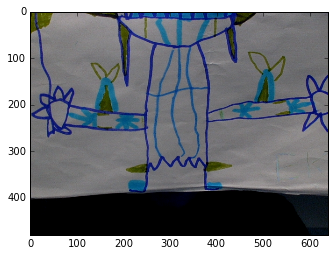

In [4]:
start = time.time()
cam = Source()
img = cam.grab()
img = cam.grab()
cam.close()
print('Time to start, grab 2 frames and stop = ',  time.time() - start , '(s)')
print(img.shape, img.min(), img.max())
plt.imshow(img)

## how fast do we grab frames?

In [5]:
N = 100
ctime = np.zeros(N)
start = time.time()
cam = Source()
for i in range(N):
    img = cam.grab()
    ctime[i] = time.time() - start
cam.close()

FPS :  30.2661328841


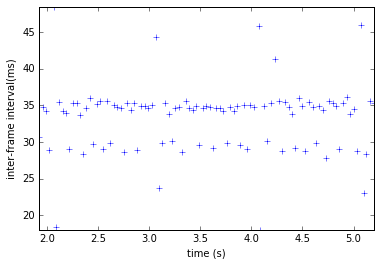

In [6]:
plt.plot(ctime[1:], np.diff(ctime)*1000, '+')
plt.xlabel('time (s)')
plt.ylabel('inter-frame interval(ms)')
_ = plt.axis('tight')
print ('FPS : ',  N/(ctime[-1]-ctime[0]))

## closing the camera

In [7]:
cam.cap.isOpened()

False

In [8]:
cam.cap.release()

## threaded mode

Following the documentation @ http://docs.opencv.org/modules/highgui/doc/reading_and_writing_images_and_video.html?highlight=imread it is easy to run parallel captures :

In [9]:
from multiprocessing.pool import ThreadPool
from collections import deque
import cv2
import time

class StatValue:
    def __init__(self, smooth_coef = 0.5):
        self.value = None
        self.smooth_coef = smooth_coef
    def update(self, v):
        if self.value is None:
            self.value = v
        else:
            c = self.smooth_coef
            self.value = c * self.value + (1.0-c) * v

def clock():
    return cv2.getTickCount() / cv2.getTickFrequency()

def draw_str(dst, target, s):
    x, y = target
    cv2.putText(dst, s, (x+1, y+1), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), thickness = 2, lineType=cv2.LINE_AA)
    cv2.putText(dst, s, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)


class ThreadSource:
    def __init__(self, w=640, h=480, threads=True):
        self.h, self.w = h, w
        import cv2
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.w)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.h)

        if threads:
            self.threadn = cv2.getNumberOfCPUs()
        else:
            self.threadn = 1
        self.pool = ThreadPool(processes = self.threadn)
        self.pending = deque()

        self.latency = StatValue()
        self.frame_interval = StatValue()
        self.last_frame_time = clock()        
        self.display = False
        self.ctime = []
        self.N = 0

    def process_frame(self, frame, t0):
        # some intensive computation...
        frame = cv2.medianBlur(frame, 19)
        time.sleep(.1)
        frame = cv2.medianBlur(frame, 19)
        return frame, t0

    def run(self, T=10):
        start = clock()
        while clock()-start <10.:
            while len(self.pending) > 0 and self.pending[0].ready():
                res, t0 = self.pending.popleft().get()
                self.latency.update(clock() - t0)
                if self.display:
                    draw_str(res, (20, 40), "latency        :  %.1f ms" % (self.latency.value*1000))
                    draw_str(res, (20, 60), "frame interval :  %.1f ms" % (self.frame_interval.value*1000))
                    cv2.imshow('Webcam video', res)
                self.ctime.append(time.time() - start)
                self.N += 1
            if len(self.pending) < self.threadn:
                ret, frame = self.cap.read()
                t = clock()
                self.frame_interval.update(t - self.last_frame_time)
                self.last_frame_time = t
                task = self.pool.apply_async(self.process_frame, (frame.copy(), t))
                self.pending.append(task)
            ch = 0xFF & cv2.waitKey(1)
            if ch == 27:
                self.close()
    
    def close(self):
        self.cap.release()
        if self.display: cv2.destroyAllWindows()

start = time.time()
cam = ThreadSource()
ctime = cam.run()
cam.close()
start_nothreads = time.time()
cam_nothreads = ThreadSource(threads=False)
ctime = cam_nothreads.run()
cam_nothreads.close()

FPS threaded:  20.007816955363253
FPS one thread:  5.315807512145591


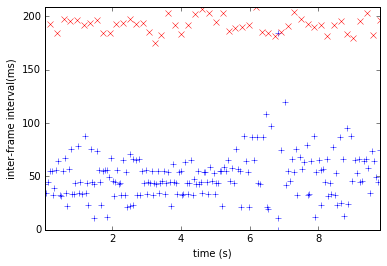

In [10]:
plt.plot(np.array(cam.ctime)[1:]-cam.ctime[0], np.diff(np.array(cam.ctime))*1000, 'b+')
plt.plot(np.array(cam_nothreads.ctime)[1:]-cam_nothreads.ctime[0], np.diff(np.array(cam_nothreads.ctime))*1000, 'rx')
plt.xlabel('time (s)')
plt.ylabel('inter-frame interval(ms)')
_ = plt.axis('tight')
print ('FPS threaded: ',  cam.N/(cam.ctime[-1]-cam.ctime[0]))
print ('FPS one thread: ',  cam_nothreads.N/(cam_nothreads.ctime[-1]-cam_nothreads.ctime[0]))

In practice, we will see nice improvments when the image processing pipeline is more consequent.

##  creating a video for debugging

It may be sometimes useful to just read out some frames for debugging.

In [24]:
import os
N_frame = 512 # how much you want?
folder = '/tmp/debug' # where we do save the frames
try: 
    os.mkdir(folder)
except: pass

from LeCheapEyeTracker import LeCheapEyeTracker
cam = LeCheapEyeTracker()
start = cam.clock()
for i in range(N_frame):
    ret, frame = cam.cap.read()
    t = cam.clock() - start   
    # https://docs.python.org/3.3/library/string.html#format-examples
    timestr = '{t:03.5f}'.format(t=t).replace('.', '_')
    fname = 'frame_{i}_at_{t}.png'.format(i=i, t=timestr)
    print(fname)
    cv2.imwrite(os.path.join(folder, fname), frame)

cam.close()

frame_0_at_0_00110.png
frame_1_at_0_03537.png
frame_2_at_0_06199.png
frame_3_at_0_10683.png
frame_4_at_0_13822.png
frame_5_at_0_16574.png
frame_6_at_0_20488.png
frame_7_at_0_23582.png
frame_8_at_0_26808.png
frame_9_at_0_32143.png
frame_10_at_0_35191.png
frame_11_at_0_36774.png
frame_12_at_0_40548.png
frame_13_at_0_43303.png
frame_14_at_0_46484.png
frame_15_at_0_50371.png
frame_16_at_0_53531.png
frame_17_at_0_56895.png
frame_18_at_0_59697.png
frame_19_at_0_63532.png
frame_20_at_0_66170.png
frame_21_at_0_69547.png
frame_22_at_0_73815.png
frame_23_at_0_77159.png
frame_24_at_0_80359.png
frame_25_at_0_83709.png
frame_26_at_0_86957.png
frame_27_at_0_90280.png
frame_28_at_0_93617.png
frame_29_at_0_97015.png
frame_30_at_1_00238.png
frame_31_at_1_03165.png
frame_32_at_1_06564.png
frame_33_at_1_10653.png
frame_34_at_1_14056.png
frame_35_at_1_17354.png
frame_36_at_1_20698.png
frame_37_at_1_23556.png
frame_38_at_1_26925.png
frame_39_at_1_30413.png
frame_40_at_1_33645.png
frame_41_at_1_37119.png
fr